In [1]:
import urllib
import pyodbc
import lifelines
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import matplotlib as mpl

from matplotlib import pyplot as plt
from importlib import reload

In [2]:
with open('dbmi-aetna-cxn-str') as f:
    cxn_params = f.read().strip()
    gmw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=gmw3')
    aetna_raw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=AetnaDataWarehouse')
    hy_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=hy180')
    
engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % gmw_cxn_str, connect_args = {'autocommit':True})
cxn = engine.connect()
ins = sqla.inspect(engine)

hy_engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % hy_cxn_str, connect_args = {'autocommit': True, 'fast_executemany': True})
hy_cxn = hy_engine.connect()

In [3]:
print(ins.get_table_names())

['ConceptDiagnosis', 'ConceptDiagnosisDRG', 'ConceptDiagnosisMDC', 'ConceptEnrollment', 'ConceptLab', 'ConceptMedication', 'ConceptProcedure', 'ConceptProcedureICD', 'ConceptProcedureNoModifier', 'ConceptZipCode', 'DistinctDiagnosis', 'DistinctDiagnosisDRG', 'DistinctDiagnosisMDC', 'DistinctEnrollment', 'DistinctLab', 'DistinctMedication', 'DistinctPCP', 'DistinctProcedure', 'DistinctProcedureICD', 'DistinctProcedureNoModifier', 'Member', 'MemberDemographics', 'MemberDiagnosis', 'MemberDiagnosisDRG', 'MemberDiagnosisMDC', 'MemberEnrollment', 'MemberLab', 'MemberMedication', 'MemberProcedure', 'MemberProcedureICD', 'MemberVisit', 'MemberZipCode', 'ObservationDiagnosis', 'ObservationLab', 'ObservationMedication', 'ObservationProcedure', 'ObservationProcedureICD', 'Summary', 'VisitIcdVersion', 'VisitMedicalClaim']


In [5]:
# Print table col names + example row

tab = 'ConceptMedication'
print([r['name'] for r in ins.get_columns(tab)])
pd.read_sql("select top 10 * from %s order by newid()" % tab, cxn)

['NationalDrugCode', 'NdcDescription', 'NumberOfPatients', 'NumberOfClaims', 'NumberOfMaintenancePatients', 'NumberOfMaintenanceClaims', 'FirstDispenseDate', 'LastDispenseDate', 'FirstPaidDate', 'LastPaidDate', 'TotalQuantity', 'TotalDaysSupply', 'MaxTotalQuantity', 'MaxTotalDaysSupply', 'MaxQuantity', 'MaxDaysSupply', 'TotalDeductibleAmount', 'TotalMemberOutOfPocketAmount', 'TotalPaidAmount', 'MaxTotalDeductibleAmount', 'MaxTotalMemberOutOfPocketAmount', 'MaxTotalPaidAmount']


,NationalDrugCode,NdcDescription,NumberOfPatients,NumberOfClaims,NumberOfMaintenancePatients,NumberOfMaintenanceClaims,FirstDispenseDate,LastDispenseDate,FirstPaidDate,LastPaidDate,...,MaxTotalQuantity,MaxTotalDaysSupply,MaxQuantity,MaxDaysSupply,TotalDeductibleAmount,TotalMemberOutOfPocketAmount,TotalPaidAmount,MaxTotalDeductibleAmount,MaxTotalMemberOutOfPocketAmount,MaxTotalPaidAmount
0,781341315,AMPICILLIN INJ 2GM,1,5,0,0,2011-03-01,2011-04-08,2011-03-25,2011-04-13,...,112.0,29,32.0,8,0.00,1.10,2747.88,0.00,1.10,2747.88
1,40986003109,NICOTINE POL GUM 2MG MINT,2,2,0,0,2016-05-24,2016-12-10,2016-05-24,2016-12-10,...,40.0,4,40.0,4,0.00,0.00,14.33,0.00,0.00,9.30
2,47781026305,OXYCODONE TAB 5MG,1570,5013,0,0,2014-04-25,2017-06-30,2014-04-25,2017-06-30,...,9690.0,930,540.0,90,3869.84,17249.18,77168.29,513.72,603.97,2551.69
3,10019002232,KETOROLAC INJ 60MG/2ML,29,32,0,0,2008-03-13,2012-08-30,2008-03-13,2012-08-30,...,20.0,30,20.0,30,9.00,147.88,191.38,9.00,10.00,29.80
4,781197101,DESIPRAMINE TAB 10MG,2078,9718,2078,9718,2008-01-02,2017-05-26,2008-01-02,2017-06-16,...,28350.0,4220,720.0,90,15042.91,102093.98,286972.54,627.47,1535.00,22936.43
5,89117000001,NASONEB NSL MIS REPLACEM,1,1,0,0,2014-02-21,2014-02-21,2014-02-21,2014-02-21,...,1.0,1,1.0,1,0.00,153.28,0.00,0.00,153.28,0.00
6,332415530,AMOXICILLIN SUS 250/5ML,2,2,0,0,2008-02-27,2011-01-06,2008-02-27,2012-03-12,...,150.0,10,150.0,10,0.00,11.40,10.00,0.00,11.40,10.00
7,49452439502,MEBENDAZOLE POW,3,19,0,0,2013-07-21,2013-11-10,2013-11-10,2015-11-16,...,9.0,9,3.0,1,0.00,180.56,0.00,0.00,153.00,0.00
8,68645032054,OMEPRAZOLE CAP 20MG,5329,59384,5329,59384,2012-04-17,2017-04-05,2012-04-17,2017-04-22,...,7800.0,3960,720.0,365,53827.40,357705.79,620360.81,1522.80,1522.80,4607.26
9,68330000210,CEFTRIAXONE INJ 500MG,20,23,0,0,2008-10-17,2010-12-17,2008-12-07,2011-06-11,...,8.0,7,7.0,7,40.89,89.32,1012.24,40.89,40.89,193.43


# Population characteristics

<BarContainer object of 122 artists>

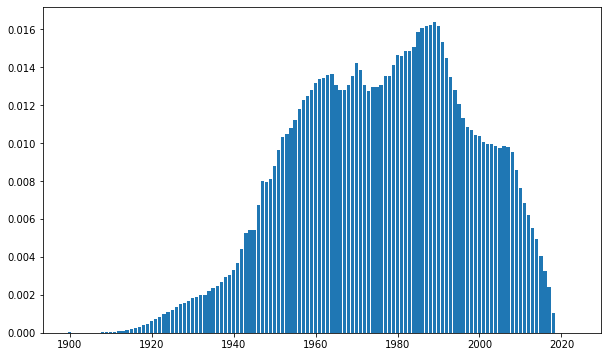

In [6]:
# patients by birth year
query = 'select BirthYearMinus1900+1900 as byear,count(MemberNum) as membersFromBY from Member with (nolock) group by BirthYearMinus1900'
patients_by_birthyear = pd.read_sql(query, con=cxn, index_col='byear')
patients_by_birthyear.dropna(axis=0, inplace=True)
patients_by_birthyear.sort_values(by='byear', ascending=True,inplace=True)
patients_by_birthyear['propTotalPatients'] = patients_by_birthyear.membersFromBY / patients_by_birthyear.membersFromBY.sum()

plt.figure(figsize=(10, 6))
plt.bar(x=patients_by_birthyear.index, height=patients_by_birthyear.propTotalPatients, align='center')

## Glucose tests by age

In [7]:
# temp table for glucose tests per patient
glucose_lab_procs = ('82947', '')
tmp_query = ("select MemberNum, datepart(yyyy, DateServiceStarted) as year, LineLevelProcedureCode as cpt "
             " into #hytmp from ObservationProcedure with (nolock) "
             " where LineLevelProcedureCodeType='C' and LineLevelProcedureCode in %s;" % str(glucose_lab_procs))
cxn.execute(tmp_query)

# count glucose measurements in each byear bucket per year
query = ("select t.year, count(*) as tests, t1.BirthYearMinus1900 + 1900 as byear"
        " from (select MemberNum, BirthYearMinus1900 from Member) as t1 "
        " join #hytmp as t on (t.MemberNum=t1.MemberNum)"
        " group by year, t1.BirthYearMinus1900;")
glucose_per_year = pd.read_sql(query, cxn, index_col=['byear'])

normalized_gpy = glucose_per_year.join(patients_by_birthyear, on='byear')
normalized_gpy['testsPerMember'] = normalized_gpy.tests / normalized_gpy.membersFromBY
normalized_gpy['age'] = normalized_gpy.year - normalized_gpy.index

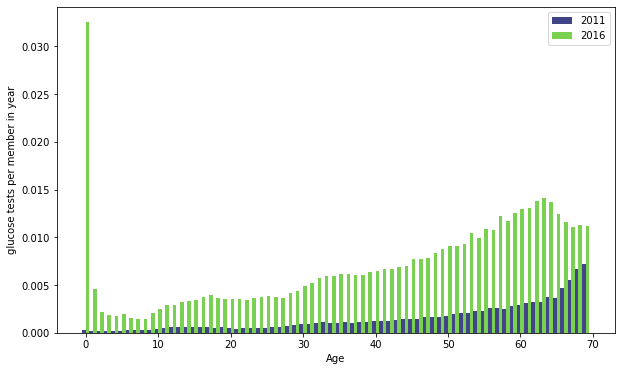

In [8]:
y_old = 2011
y_new = 2016
age_thres = 70

old_data = normalized_gpy.loc[(normalized_gpy.year == y_old) & (normalized_gpy.age < age_thres)].sort_values(by='byear')
new_data = normalized_gpy.loc[(normalized_gpy.year == y_new) & (normalized_gpy.age < age_thres)].sort_values(by='byear')

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
old_bars = ax.bar(x=old_data.age.values-.5, height=old_data.testsPerMember, align='edge', width=.5, color=mpl.cm.viridis(.2))
new_bars = ax.bar(x=new_data.age.values, height=new_data.testsPerMember, align='edge', width=.5, color=mpl.cm.viridis(.8))
# ax.bar(x=patients_by_birthyear.index, height=patients_by_birthyear.propTotalPatients, align='center')

plt.xlabel('Age')
plt.ylabel('glucose tests per member in year')
ax.legend(handles=[old_bars, new_bars], labels=[y_old, y_new])

# eMerge T2DM algorithms

In [9]:
glucose_tests_loinc = ('1558-6', '2339-0', '2345-7')
a1c_tests_loinc = ('4548-4', '17856-6', '4549-2', '17855-8')

glucose_max = 110.
a1c_max = 6.

abnormal_labs_query = ("drop table if exists #abnormalLabs;"
                      " select *"
                      " into #abnormalLabs"
                      " from GlucoseLabs"
                      " where (LoincCode in %s and maxValue > %f) or (LoincCode in %s and maxValue > %f)"
                       % (glucose_tests_loinc, glucose_max, a1c_tests_loinc, a1c_max))
hy_cxn.execute(abnormal_labs_query)

## Cases

In [10]:
# t2d dx + rx for both t1d and t2d + first treated for t2d
gr1_query = ("drop table if exists #t2dCaseGroup1;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup1"
            " from (select MemberNum from DxT2dm) as t1"
            "      inner join (select MemberNum, min(FirstDispenseDate) as firstRxT1dm from RxT1Dm group by MemberNum) as t2"
            "        on t1.MemberNum=t2.MemberNum"
            "      inner join (select MemberNum, min(FirstDispenseDate) as firstRxT2dm from RxT2Dm group by MemberNum) as t3"
            "        on t2.MemberNum=t3.MemberNum"
            " where firstRxT2dm < firstRxT1dm"
            )

# t2d dx + rx for t2d but not t1d
gr2_query = ("drop table if exists #t2dCaseGroup2;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup2"
            " from (select MemberNum from DxT2dm) as t1"
            "      inner join (select MemberNum from RxT2Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup2"
            " where MemberNum in (select MemberNum from RxT1Dm)"
            )

# t2d dx + no rx + abnormal labs
gr3_query = ("drop table if exists #t2dCaseGroup3;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup3"
            " from (select MemberNum from DxT2dm) as t1"
            "      inner join (select MemberNum from #abnormalLabs) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup3"
            " where MemberNum in (select MemberNum from RxT1Dm union select MemberNum from RxT2Dm)"
            )

# No t2d dx + t2d rx + abnormal lab
gr4_query = ("drop table if exists #t2dCaseGroup4;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup4"
            " from (select MemberNum from #abnormalLabs) as t1"
            "      inner join (select MemberNum from RxT2Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum;"
            " delete from #t2dCaseGroup4"
            " where MemberNum in (select MemberNum from DxT2dm)"
            )

# t2d dx + rx for t1d but not t2d + at least 2 dx for t2d
gr5_query = ("drop table if exists #t2dCaseGroup5;"
            " select distinct t1.MemberNum"
            " into #t2dCaseGroup5"
            " from (select MemberNum, sum(numClaims) as totNumClaims from DxT2dm group by MemberNum) as t1"
            "      inner join (select MemberNum from RxT1Dm) as t2"
            "        on t1.MemberNum=t2.MemberNum"
            " where totNumClaims > 1"
            " delete from #t2dCaseGroup2"
            " where MemberNum in (select MemberNum from RxT2Dm)"
            )

hy_cxn.execute(';'.join([gr1_query, gr2_query, gr3_query, gr4_query, gr5_query]))

In [11]:
case_query = ("drop table if exists t2dCaseEmerge;"
             " select distinct MemberNum"
             " into t2dCaseEmerge"
             " from (select * from #t2dCaseGroup1 union select * from #t2dCaseGroup2 union select * from #t2dCaseGroup3 union select * from #t2dCaseGroup4 union select * from #t2dCaseGroup5) as t1;"
             " delete from t2dCaseEmerge"
             " where MemberNum in (select MemberNum from DxT1dm)"
             )
hy_cxn.execute(case_query)

In [12]:
pd.read_sql('select count(*) from t2dCaseEmerge', hy_cxn)

,
0,1014502


## Controls

In [14]:
# Keep patients with multiple visits & any glucose lab value 
pos_query = ("drop table if exists t2dControlEmerge;"
            " select t1.MemberNum"
            " into t2dControlEmerge"
            " from (select distinct MemberNum from VisitCount where visits > 1) as t1"
            " inner join (select distinct MemberNum from GlucoseLabs) as t2"
            " on t1.MemberNum=t2.MemberNum")

# Remove patients with DM dx (incl family hx) or abnormal labs
neg_query = ("delete from t2dControlEmerge"
            " where MemberNum in"
            " (select distinct MemberNum from DxDm"
            "  union select distinct MemberNum from #abnormalLabs"
            "  union select distinct MemberNum from RxDm)")

hy_cxn.execute(';'.join([pos_query, neg_query]))

In [15]:
pd.read_sql('select count(*) from t2dControlEmerge', hy_cxn)

,
0,7595503


## Gap between claims

In [7]:
sqla.inspect(hy_engine).get_table_names()

['ClaimsDm',
 'depressionTTE',
 'dmTTE',
 'DxDm',
 'DxT1dm',
 'DxT2dm',
 'GlucoseLabs',
 'RxDm',
 'RxIngredients',
 'RxInsulin',
 'RxT1Dm',
 'RxT2dm',
 't2dCaseEmerge',
 't2dControlEmerge',
 'VisitCount']

In [7]:
dm_dx_icd = str(('790.21', '790.22', '790.2', '790.29', '791.5', '277.7', 'V18.0', 'V77.1'))
dm_dx_icd_fuzzy = ' or '.join(["DiagnosisCode like '%s'" % s for s in ('250%', '648.8%', '648.0%')])

# ICD for Family hx included here 
diabetes_dx_query = ("drop table if exists hy180.dbo.ClaimsDm;"
                    " select MemberNum, StartDate as date"
                    " into hy180.dbo.ClaimsDm"
                    " from ObservationDiagnosis with (nolock)"
                    " where DiagnosisCode in %s"
                    " or %s" % (dm_dx_icd, dm_dx_icd_fuzzy))

queries = [("drop table if exists hy180.dbo.ClaimsDm;"
            " select t1.MemberNum, t1.StartDate as date, t2.LastMonthEndDate as enrollmentEnd"
            " into hy180.dbo.ClaimsDm"
            " from (select distinct MemberNum, StartDate "
            "       from ObservationDiagnosis with (nolock)"
            "       where (DiagnosisCode in %s or %s) and StartDate between '20080101' and '20170701') as t1 "
            "      inner join (select MemberNum, LastMonthEndDate from MemberEnrollment) as t2 "
            "      on t1.MemberNum=t2.MemberNum"
            % (dm_dx_icd, dm_dx_icd_fuzzy)),
           ("drop table if exists #dmGaps;"
            " select *, datediff(d, date, lead(date, 1) over(partition by MemberNum order by date)) as gapToNext"
            " into #dmGaps"
            " from hy180.dbo.ClaimsDm"
           ),
           ("drop table if exists hy180.dbo.dmTTE;"
            " select t1.MemberNum, date, 119 - BirthYearMinus1900 as age, isnull(gapToNext, datediff(d, date, enrollmentEnd)) as time, case when gapToNext is null then cast(0 as bit) else cast(1 as bit) end as event"
            " into hy180.dbo.dmTTE"
            " from #dmGaps as t1 inner join Member as t2 on t1.MemberNum=t2.MemberNum"
           )]

cxn.execute('; '.join(queries))

In [10]:
df = pd.read_sql('select * from dmTTE where event=0', hy_cxn, parse_dates=['date'])

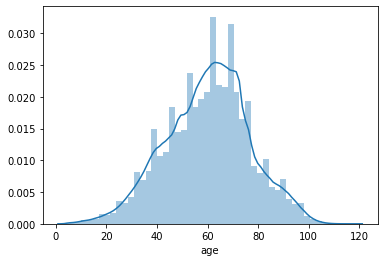

In [14]:
# distribution of claimant ages 
sns.distplot(df.drop_duplicates(subset=['MemberNum']).age.dropna())

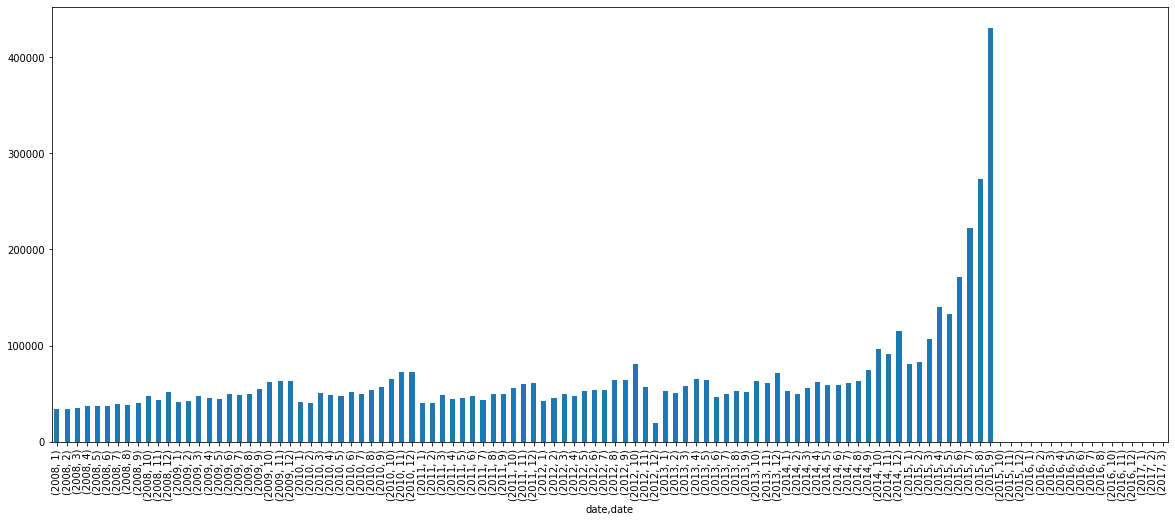

In [13]:
# Timing of last claim -> end or enrollment where time > 1000 days
df['date'].groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar", figsize=(20, 8))

In [3]:
df_gen = pd.read_sql_table('dmTTE', hy_cxn, chunksize=int(1e+6))
tte = next(df_gen)
for chunk in df_gen:
    tte = pd.concat([tte, chunk], ignore_index=True)

print(np.sum(tte.time < 0))
tte = tte[tte.time > 0]

156453


In [10]:
def plot_with_percentile(df, percentile, **kwargs):
    ax = sns.distplot(df, **kwargs)
    x = np.quantile(df, percentile)
    ax.axvline(x=x)

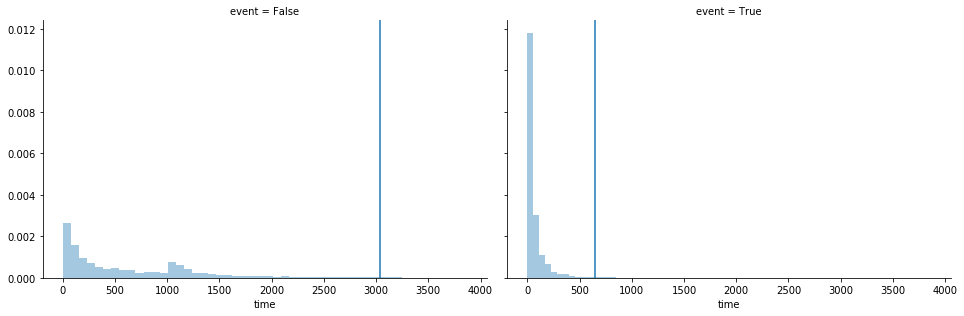

In [11]:
raise Exception('careful this takes 15G of memory')
g = sns.FacetGrid(tte, col='event', height=4.5, aspect=1.5)
g = g.map(plot_with_percentile, 'time', percentile=.99, kde=False, norm_hist=True)

In [25]:
claims_count = pd.read_sql('select t1.MemberNum, sum(numClaims) as totClaims from dxDM as t1 inner join t2dCaseEmerge as t2 on t1.MemberNum=t2.MemberNum group by t1.MemberNum', hy_cxn)
print('%d/%d' % (np.sum(claims_count.totClaims==1), claims_count.shape[0]))

68369/837297


In [14]:
np.quantile(tte.time[tte.event], .95)

258.0

# Depression

## Gap between claims 

In [24]:
depression_icds = ('293.83', '296.20', '296.21', '296.22', '296.23', '296.24', '296.25', '296.26', '296.30', '296.31', '296.32', '296.33', '296.34', '296.35', '296.36', '300.4', '311')

# Get gaps between depression claims 
queries = [("drop table if exists #depressionClaims;"
            " select t1.MemberNum, t1.StartDate as date, t2.LastMonthEndDate as enrollmentEnd"
            " into #depressionClaims"
            " from (select distinct MemberNum, StartDate from ObservationDiagnosis where DiagnosisCode in %s and StartDate < '20170701') as t1 "
            "      inner join (select MemberNum, LastMonthEndDate from MemberEnrollment) as t2 "
            "      on t1.MemberNum=t2.MemberNum"
            % str(depression_icds)),
           ("drop table if exists #depressionGaps;"
            " select *, datediff(d, date, lead(date, 1) over(partition by MemberNum order by date)) as gapToNext"
            " into #depressionGaps"
            " from #depressionClaims"
           ),
           ("drop table if exists hy180.dbo.depressionTTE;"
            " select isnull(gapToNext, datediff(d, date, enrollmentEnd)) as time, case when gapToNext is null then cast(0 as bit) else cast(1 as bit) end as event"
            " into hy180.dbo.depressionTTE"
            " from #depressionGaps"
           )]

cxn.execute('; '.join(queries))

In [15]:
pd.read_sql('select top 100 * from #dmGaps order by date desc', cxn)

,MemberNum,date,enrollmentEnd,gapToNext
0,231512161621242001,2017-03-06,2017-04-30,NaN
1,231512140501243201,2017-02-13,2018-07-31,NaN
2,231512231332173301,2017-01-12,2018-07-31,NaN
3,231512210216292201,2017-01-11,2018-07-31,NaN
4,231512232920293501,2017-01-05,2017-12-31,NaN
5,231512210513232001,2016-12-21,2018-07-31,NaN
6,231512210527142201,2016-12-20,2018-07-31,NaN
7,231512170418202601,2016-12-19,2017-12-31,NaN
8,231512182312201601,2016-12-12,2016-12-31,NaN
9,231512140620053301,2016-12-05,2018-01-31,NaN


In [5]:
df_gen = pd.read_sql_table('depressionTTE', hy_cxn, chunksize=int(1e+6))
tte = next(df_gen)
for chunk in df_gen:
    tte = pd.concat([tte, chunk], ignore_index=True)
    
tte = tte[tte.time > 0]

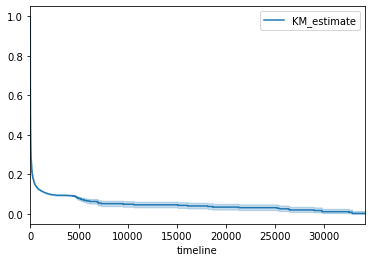

In [6]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(tte.time, event_observed=tte.event)
kmf.plot()

In [ ]:
def count_overlap(t1, t2, key_col, cxn):
    query = ("select count(*)"
            " from %s as t1 inner join %s as t2 on t1.%s=t2.%s"
            % (t1, t2, key_col, key_col))
    return cxn.execute(query).fetchone()[0]


def contingency_table(case_tablename, control_tablename, exposed_tablename, nonexposed_tablename):
    case_exposed = count_overlap(case_tablename, exposed_tablename, 'MemberNum', cxn)
    case_nonexposed = count_overlap(case_tablename, nonexposed_tablename, 'MemberNum', cxn)
    control_exposed = count_overlap(control_tablename, exposed_tablename, 'MemberNum', cxn)
    control_nonexposed = count_overlap(control_tablename, nonexposed_tablename, 'MemberNum', cxn)
    
    